In [1]:
# !pip install catboost --upgrade
# !pip install lightgbm --install-option=--gpu --upgrade
!pip install statsmodels tqdm scikit-optimize --upgrade

Requirement already up-to-date: statsmodels in /usr/local/lib/python3.6/dist-packages (0.11.0)
Requirement already up-to-date: tqdm in /usr/local/lib/python3.6/dist-packages (4.42.1)
Requirement already up-to-date: scikit-optimize in /usr/local/lib/python3.6/dist-packages (0.7.2)


In [0]:
import os
import sys

from datetime import datetime, timedelta
from collections import defaultdict
from operator import itemgetter

import scipy.signal
import numpy as np
import pandas as pd

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn

%matplotlib inline

# import lightgbm as lgb
# from catboost import CatBoostRegressor

from statsmodels.tsa.holtwinters import ExponentialSmoothing

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

In [0]:
pd.set_option('display.max_columns', 100)

### Load data

In [4]:
from google.colab import drive

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
WORKDIR = '/content/drive/My Drive/idao-2020/Track 1'

In [0]:
df_train = pd.read_csv(os.path.join(WORKDIR, "train.csv"), index_col="id", parse_dates=["epoch"])
df_test  = pd.read_csv(os.path.join(WORKDIR, "test.csv"), index_col="id", parse_dates=["epoch"])

In [7]:
df = pd.concat([df_train, df_test], sort=False)
df.sort_values(by=['sat_id', 'epoch'], inplace=True)
df.head()

,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim
id,,,,,,,,,,,,,,
0,2014-01-01 00:00:00.000,0,-8855.823863,13117.780146,-20728.353233,-0.908303,-3.808436,-2.022083,-8843.131454,13138.221690,-20741.615306,-0.907527,-3.804930,-2.024133
1,2014-01-01 00:46:43.000,0,-10567.672384,1619.746066,-24451.813271,-0.302590,-4.272617,-0.612796,-10555.500066,1649.289367,-24473.089556,-0.303704,-4.269816,-0.616468
2,2014-01-01 01:33:26.001,0,-10578.684043,-10180.467460,-24238.280949,0.277435,-4.047522,0.723155,-10571.858472,-10145.939908,-24271.169776,0.274880,-4.046788,0.718768
3,2014-01-01 02:20:09.001,0,-9148.251857,-20651.437460,-20720.381279,0.715600,-3.373762,1.722115,-9149.620794,-20618.200201,-20765.019094,0.712437,-3.375202,1.718306
4,2014-01-01 03:06:52.002,0,-6719.092336,-28929.061629,-14938.907967,0.992507,-2.519732,2.344703,-6729.358857,-28902.271436,-14992.399986,0.989382,-2.522618,2.342237


In [0]:
df['ts'] = df['epoch'].values.astype(np.int64) / 10 ** 9
df['ts_int'] = df['ts'].astype(int)

In [9]:
df.shape

(933983, 16)

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.base import TransformerMixin

class TrendExtractor(TransformerMixin):
    def __init__(self):
        self.reg_ = LinearRegression()

    def fit(self, ts, y):
        self.reg_ = self.reg_.fit(ts, y)
        return self

    def transform(self, ts, y):
        trend = self.reg_.predict(ts)
        return y - trend

    def fit_transform(self, ts, y):
        self.fit(ts, y)
        return self.transform(ts, y)

    def inverse_transform(self, ts, y):
        trend = self.reg_.predict(ts)
        return y + trend

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.base import TransformerMixin

def buckets(a, size=2):
    for i in range(0, len(a), size):
        yield a[i:i+size]

class ScaleExtractor(TransformerMixin):
    def __init__(self, period=24):
        self.reg_ = LinearRegression()
        self.period_ = period

    def fit(self, ts, y):
        ts = [b.mean() for b in buckets(ts, self.period_)]
        y  = [b.max() - b.min() for b in buckets(y, self.period_)]
        self.reg_ = self.reg_.fit(ts, y)
        return self

    def transform(self, ts, y):
        scale = self.reg_.predict(ts)
        return y / scale

    def fit_transform(self, ts, y):
        self.fit(ts, y)
        return self.transform(ts, y)

    def inverse_transform(self, ts, y):
        scale = self.reg_.predict(ts)
        return y * scale

In [0]:
COLS_TARGET = ['x', 'y', 'z', 'Vx', 'Vy', 'Vz']
COLS_TARGET_DETREND = [col + '_detrend' for col in COLS_TARGET]
COLS_TARGET_DESCALE = [col + '_descale' for col in COLS_TARGET]
COLS_TARGET_PREDICT = [col + '_predict' for col in COLS_TARGET]
COLS_TARGET_SIM = [col + '_sim' for col in COLS_TARGET]

In [13]:
SEASONS = {}

for sat_id, group in tqdm(df.groupby('sat_id')):
    scores = [(period, group[COLS_TARGET].diff(period).abs().mean().mean())
              for period in range(15, 31)]
    period = min(scores, key=itemgetter(1))[0]
    SEASONS[sat_id] = period

len(SEASONS)

600

In [14]:
import warnings

df_list = []

def prepare_group(group):
    group_new = group.drop_duplicates(subset=['ts_int'])

    period = np.median(np.diff(group_new['epoch']))
    period = int(period / np.timedelta64(1, 's'))
    period = '{}S'.format(period)

    epoch_new = pd.date_range(start=group_new['epoch'].iloc[0], periods=group_new.shape[0], freq=period)
    group_new.index = epoch_new

    return group_new

HARDCODE_SEASONS = {
    391: 25,
    515: 26,
    277: 23,
    252: 23,
    249: 25,
}

models_all = {}

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")

    for sat_id, group in tqdm(df.groupby('sat_id')):
        trend_models = {}
        for target in COLS_TARGET:
            target_detrend = target + '_detrend'

            mask = group.loc[:, target].notna()
            x, y = group.loc[mask, ['ts']], group.loc[mask, target]

            trend = TrendExtractor().fit(x, y)
            group.loc[:, target_detrend] = trend.transform(x, y)
            trend_models[target] = trend

        scale_models = {}
        for target in COLS_TARGET:
            target_detrend = target + '_detrend'
            target_descale = target + '_descale'

            scale = None
            if (sat_id == 515 and target == 'y') or \
               (sat_id == 277 and target == 'y') :
                mask = group.loc[:, target_detrend].notna()
                x, y = group.loc[mask, ['ts']], group.loc[mask, target_detrend]

                scale = ScaleExtractor(period=24).fit(x, y)
                group.loc[:, target_descale] = scale.transform(x, y)
            else:
                group.loc[:, target_descale] = group.loc[:, target_detrend]
            scale_models[target] = scale       

        group = group.reset_index()
        group_new = prepare_group(group)

        smoothing_models = {}
        for target in COLS_TARGET:
            target_descale = target + '_descale'
            target_predict = target + '_predict'

            seasonal_periods = HARDCODE_SEASONS.get(sat_id, 24)

            mask = group_new.loc[:, target].notna()
            smooth = ExponentialSmoothing(group_new.loc[mask, target_descale],
                                          trend=None, seasonal='add',
                                          seasonal_periods=seasonal_periods).fit()
            smoothing_models[target] = smooth

            prediction = smooth.predict(start=group_new.index[0], end=group_new.index[-1])
            prediction = prediction.rename(target_predict)
            prediction = pd.concat([group_new[['ts_int']], prediction], axis=1)
            prediction = pd.merge(group[['ts_int', 'ts']], prediction, on='ts_int')
            
            scale = scale_models[target]
            if scale is not None:
                prediction.loc[:, target_predict] = \
                    scale.inverse_transform(prediction[['ts']], prediction[target_predict])
            
            trend = trend_models[target]
            if trend is not None:
                prediction.loc[:, target_predict] = \
                    trend.inverse_transform(prediction[['ts']], prediction[target_predict])

            prediction = prediction.sort_values(by='ts')
            group = pd.concat([group, prediction[target_predict]], axis=1)

        models_all[sat_id] = {
            'trend':  trend_models,
            'scale':  scale_models,
            'smooth': smoothing_models,
        }
        
        df_list.append(group)

df = pd.concat(df_list)
df.head()

,id,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim,ts,ts_int,x_detrend,y_detrend,z_detrend,Vx_detrend,Vy_detrend,Vz_detrend,x_descale,y_descale,z_descale,Vx_descale,Vy_descale,Vz_descale,x_predict,y_predict,z_predict,Vx_predict,Vy_predict,Vz_predict
0,0,2014-01-01 00:00:00.000,0,-8855.823863,13117.780146,-20728.353233,-0.908303,-3.808436,-2.022083,-8843.131454,13138.221690,-20741.615306,-0.907527,-3.804930,-2.024133,1.388534e+09,1388534400,-13495.224946,20789.555425,-31599.686661,-0.922692,-3.736007,-2.057280,-13495.224946,20789.555425,-31599.686661,-0.922692,-3.736007,-2.057280,4706.333756,13112.940328,11146.979138,0.065219,-0.046090,0.105999
1,1,2014-01-01 00:46:43.000,0,-10567.672384,1619.746066,-24451.813271,-0.302590,-4.272617,-0.612796,-10555.500066,1649.289367,-24473.089556,-0.303704,-4.269816,-0.616468,1.388537e+09,1388537203,-15207.619805,9291.288763,-35324.491295,-0.316965,-4.200336,-0.647957,-15207.619805,9291.288763,-35324.491295,-0.316965,-4.200336,-0.647957,1566.807894,1614.764969,4068.070959,0.619689,-0.906326,1.403275
2,2,2014-01-01 01:33:26.001,0,-10578.684043,-10180.467460,-24238.280949,0.277435,-4.047522,0.723155,-10571.858472,-10145.939908,-24271.169776,0.274880,-4.046788,0.718768,1.388540e+09,1388540006,-15219.177803,-2509.157346,-35112.303570,0.263074,-3.975388,0.688031,-15219.177803,-2509.157346,-35112.303570,0.263074,-3.975388,0.688031,278.409330,-10185.695721,1279.375995,1.151168,-1.035594,2.633110
3,3,2014-01-01 02:20:09.001,0,-9148.251857,-20651.437460,-20720.381279,0.715600,-3.373762,1.722115,-9149.620794,-20618.200201,-20765.019094,0.712437,-3.375202,1.718306,1.388543e+09,1388542809,-13789.291954,-12980.359929,-31595.748495,0.701252,-3.301775,1.687026,-13789.291954,-12980.359929,-31595.748495,0.701252,-3.301775,1.687026,565.924109,-20656.825548,2111.086434,1.543342,-0.678894,3.531539
4,4,2014-01-01 03:06:52.002,0,-6719.092336,-28929.061629,-14938.907967,0.992507,-2.519732,2.344703,-6729.358857,-28902.271436,-14992.399986,0.989382,-2.522618,2.342237,1.388546e+09,1388545612,-11360.678771,-21258.216680,-25815.619780,0.978173,-2.447891,2.309650,-11360.678771,-21258.216680,-25815.619780,0.978173,-2.447891,2.309650,1972.480204,-28934.560922,5489.139913,1.776680,-0.108548,4.058888


In [15]:
ntop = 24 * 3

df_list = []
for sat_id, group in tqdm(df.groupby('sat_id')):
    group_fix = group.iloc[:ntop]

    values_target = group_fix[COLS_TARGET].values
    values_predict = group_fix[COLS_TARGET_PREDICT].values
    values_sim = group_fix[COLS_TARGET_SIM].values
    
    error_predict = np.abs(values_target - values_predict)
    error_sim = np.abs(values_target - values_sim)
    group_fix.loc[:, COLS_TARGET_PREDICT] = np.where(error_predict < error_sim, values_predict, values_sim)

    group.iloc[:ntop] = group_fix
    df_list.append(group)

df = pd.concat(df_list)
df.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,id,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim,ts,ts_int,x_detrend,y_detrend,z_detrend,Vx_detrend,Vy_detrend,Vz_detrend,x_descale,y_descale,z_descale,Vx_descale,Vy_descale,Vz_descale,x_predict,y_predict,z_predict,Vx_predict,Vy_predict,Vz_predict
0,0,2014-01-01 00:00:00.000000000,0,-8855.823863,13117.780146,-20728.353233,-0.908303,-3.808436,-2.022083,-8843.131454,13138.221690,-20741.615306,-0.907527,-3.804930,-2.024133,1.388534e+09,1388534400,-13495.224946,20789.555425,-31599.686661,-0.922692,-3.736007,-2.057280,-13495.224946,20789.555425,-31599.686661,-0.922692,-3.736007,-2.057280,-8843.131454,13112.940328,-20741.615306,-0.907527,-3.804930,-2.024133
1,1,2014-01-01 00:46:43.000000000,0,-10567.672384,1619.746066,-24451.813271,-0.302590,-4.272617,-0.612796,-10555.500066,1649.289367,-24473.089556,-0.303704,-4.269816,-0.616468,1.388537e+09,1388537203,-15207.619805,9291.288763,-35324.491295,-0.316965,-4.200336,-0.647957,-15207.619805,9291.288763,-35324.491295,-0.316965,-4.200336,-0.647957,-10555.500066,1614.764969,-24473.089556,-0.303704,-4.269816,-0.616468
2,2,2014-01-01 01:33:26.000999936,0,-10578.684043,-10180.467460,-24238.280949,0.277435,-4.047522,0.723155,-10571.858472,-10145.939908,-24271.169776,0.274880,-4.046788,0.718768,1.388540e+09,1388540006,-15219.177803,-2509.157346,-35112.303570,0.263074,-3.975388,0.688031,-15219.177803,-2509.157346,-35112.303570,0.263074,-3.975388,0.688031,-10571.858472,-10185.695721,-24271.169776,0.274880,-4.046788,0.718768
3,3,2014-01-01 02:20:09.000999936,0,-9148.251857,-20651.437460,-20720.381279,0.715600,-3.373762,1.722115,-9149.620794,-20618.200201,-20765.019094,0.712437,-3.375202,1.718306,1.388543e+09,1388542809,-13789.291954,-12980.359929,-31595.748495,0.701252,-3.301775,1.687026,-13789.291954,-12980.359929,-31595.748495,0.701252,-3.301775,1.687026,-9149.620794,-20656.825548,-20765.019094,0.712437,-3.375202,1.718306
4,4,2014-01-01 03:06:52.001999872,0,-6719.092336,-28929.061629,-14938.907967,0.992507,-2.519732,2.344703,-6729.358857,-28902.271436,-14992.399986,0.989382,-2.522618,2.342237,1.388546e+09,1388545612,-11360.678771,-21258.216680,-25815.619780,0.978173,-2.447891,2.309650,-11360.678771,-21258.216680,-25815.619780,0.978173,-2.447891,2.309650,-6729.358857,-28934.560922,-14992.399986,0.989382,-2.522618,2.342237


In [16]:
from collections import Counter

Counter(SEASONS.values())

Counter({23: 2, 24: 589, 25: 8, 26: 1})

In [17]:
df.shape

(933983, 35)

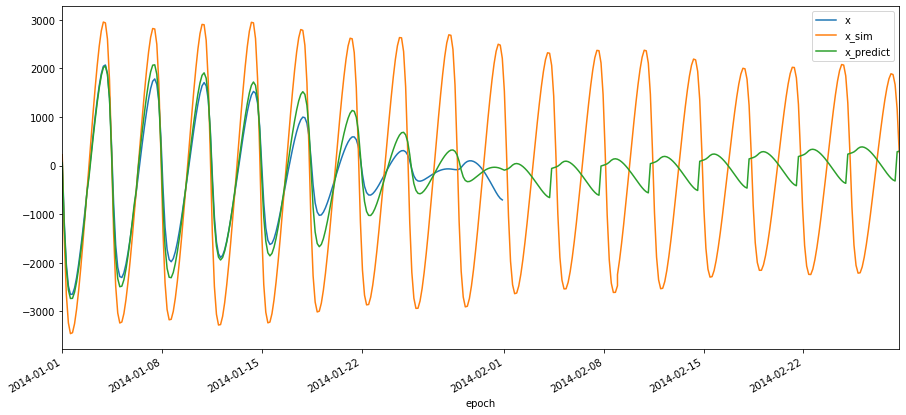

In [18]:
df_grouped = df.groupby('sat_id')
group = df_grouped.get_group(310)

fig, ax = plt.subplots(1, 1, figsize=(15, 7))

col = 'x'
col_sim = col + '_sim'
col_predict = col + '_predict'

group.plot(x='epoch', y=col, ax=ax)
group.plot(x='epoch', y=col_sim, ax=ax)
group.plot(x='epoch', y=col_predict, ax=ax)

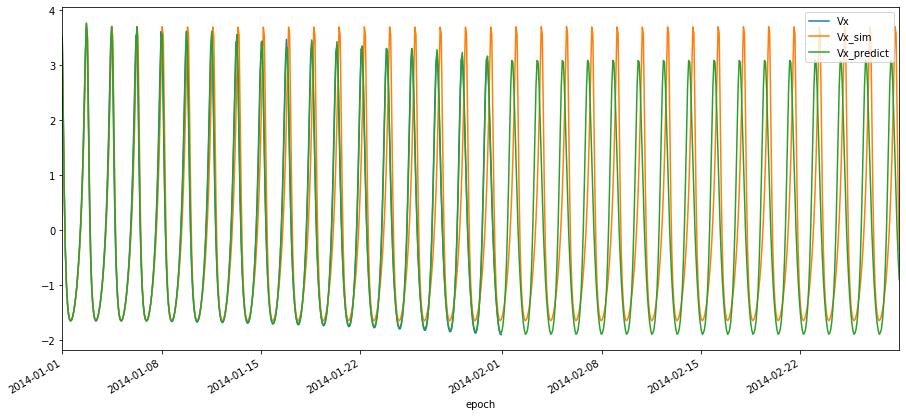

In [19]:
df_grouped = df.groupby('sat_id')
group = df_grouped.get_group(6)

fig, ax = plt.subplots(1, 1, figsize=(15, 7))

col = 'Vx'
col_sim = col + '_sim'
col_predict = col + '_predict'

group.plot(x='epoch', y=col, ax=ax)
group.plot(x='epoch', y=col_sim, ax=ax)
group.plot(x='epoch', y=col_predict, ax=ax)

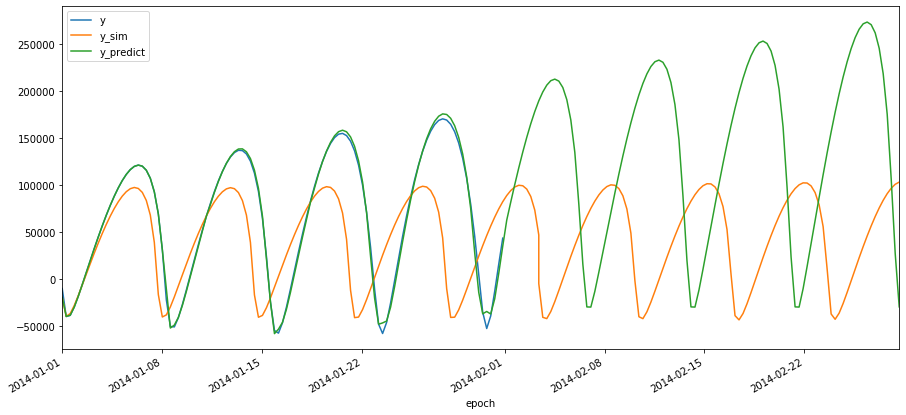

In [20]:
df_grouped = df.groupby('sat_id')
group = df_grouped.get_group(515)

fig, ax = plt.subplots(1, 1, figsize=(15, 7))

col = 'y'
col_sim = col + '_sim'
col_predict = col + '_predict'

group.plot(x='epoch', y=col, ax=ax)
group.plot(x='epoch', y=col_sim, ax=ax)
group.plot(x='epoch', y=col_predict, ax=ax)

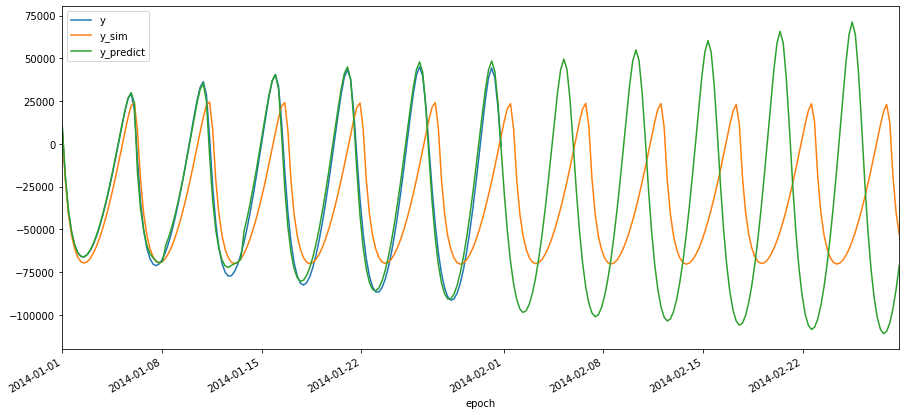

In [21]:
df_grouped = df.groupby('sat_id')
group = df_grouped.get_group(277)

fig, ax = plt.subplots(1, 1, figsize=(15, 7))

col = 'y'
col_sim = col + '_sim'
col_predict = col + '_predict'

group.plot(x='epoch', y=col, ax=ax)
group.plot(x='epoch', y=col_sim, ax=ax)
group.plot(x='epoch', y=col_predict, ax=ax)

### Submission

In [22]:
mask = df[COLS_TARGET].isna().any(axis=1)
df_train, df_test = df[~mask], df[mask]
df_test.drop(columns=COLS_TARGET, inplace=True)
df_train.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,id,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim,ts,ts_int,x_detrend,y_detrend,z_detrend,Vx_detrend,Vy_detrend,Vz_detrend,x_descale,y_descale,z_descale,Vx_descale,Vy_descale,Vz_descale,x_predict,y_predict,z_predict,Vx_predict,Vy_predict,Vz_predict
0,0,2014-01-01 00:00:00.000000000,0,-8855.823863,13117.780146,-20728.353233,-0.908303,-3.808436,-2.022083,-8843.131454,13138.221690,-20741.615306,-0.907527,-3.804930,-2.024133,1.388534e+09,1388534400,-13495.224946,20789.555425,-31599.686661,-0.922692,-3.736007,-2.057280,-13495.224946,20789.555425,-31599.686661,-0.922692,-3.736007,-2.057280,-8843.131454,13112.940328,-20741.615306,-0.907527,-3.804930,-2.024133
1,1,2014-01-01 00:46:43.000000000,0,-10567.672384,1619.746066,-24451.813271,-0.302590,-4.272617,-0.612796,-10555.500066,1649.289367,-24473.089556,-0.303704,-4.269816,-0.616468,1.388537e+09,1388537203,-15207.619805,9291.288763,-35324.491295,-0.316965,-4.200336,-0.647957,-15207.619805,9291.288763,-35324.491295,-0.316965,-4.200336,-0.647957,-10555.500066,1614.764969,-24473.089556,-0.303704,-4.269816,-0.616468
2,2,2014-01-01 01:33:26.000999936,0,-10578.684043,-10180.467460,-24238.280949,0.277435,-4.047522,0.723155,-10571.858472,-10145.939908,-24271.169776,0.274880,-4.046788,0.718768,1.388540e+09,1388540006,-15219.177803,-2509.157346,-35112.303570,0.263074,-3.975388,0.688031,-15219.177803,-2509.157346,-35112.303570,0.263074,-3.975388,0.688031,-10571.858472,-10185.695721,-24271.169776,0.274880,-4.046788,0.718768
3,3,2014-01-01 02:20:09.000999936,0,-9148.251857,-20651.437460,-20720.381279,0.715600,-3.373762,1.722115,-9149.620794,-20618.200201,-20765.019094,0.712437,-3.375202,1.718306,1.388543e+09,1388542809,-13789.291954,-12980.359929,-31595.748495,0.701252,-3.301775,1.687026,-13789.291954,-12980.359929,-31595.748495,0.701252,-3.301775,1.687026,-9149.620794,-20656.825548,-20765.019094,0.712437,-3.375202,1.718306
4,4,2014-01-01 03:06:52.001999872,0,-6719.092336,-28929.061629,-14938.907967,0.992507,-2.519732,2.344703,-6729.358857,-28902.271436,-14992.399986,0.989382,-2.522618,2.342237,1.388546e+09,1388545612,-11360.678771,-21258.216680,-25815.619780,0.978173,-2.447891,2.309650,-11360.678771,-21258.216680,-25815.619780,0.978173,-2.447891,2.309650,-6729.358857,-28934.560922,-14992.399986,0.989382,-2.522618,2.342237


In [23]:
submit = pd.read_csv(os.path.join(WORKDIR, "submission.csv"), index_col="id")

for col in submit.columns:
    submit[col] = 0

for target in tqdm(COLS_TARGET, leave=False):
    target_predict = target + '_predict'
    y_pred = df_test[target_predict].values
    submit[target] += y_pred

In [24]:
submit.to_csv(os.path.join(WORKDIR, "cv_41_models.csv"), header=True, index=True)
submit.head()

,x,y,z,Vx,Vy,Vz
id,,,,,,
3927,-24822.252229,-10935.048159,6541.251227,2.616293,-1.311429,1.092801
3928,-21115.882389,-12418.810838,7816.868588,3.223655,-1.001508,0.902851
3929,-16602.953329,-13422.276951,8790.583096,3.885386,-0.544871,0.609940
3930,-11215.984403,-13703.861456,9291.597856,4.593785,0.155971,0.143152
3931,-4933.801453,-12841.439117,9015.977920,5.264459,1.300822,-0.646726


In [25]:
!head "{WORKDIR}/cv_41_models.csv"

id,x,y,z,Vx,Vy,Vz
3927,-24822.25222875275,-10935.048159229791,6541.2512268081555,2.6162927261843096,-1.3114293712707017,1.0928010367810188
3928,-21115.88238913073,-12418.81083807752,7816.868588022784,3.223655383147206,-1.0015081632502447,0.9028506564350636
3929,-16602.95332932616,-13422.276950784006,8790.583096206105,3.885386320129288,-0.544871460522586,0.6099401936984385
3930,-11215.984403311933,-13703.861456412571,9291.59785562153,4.59378526627677,0.15597091315698908,0.14315185210179715
3931,-4933.801453339565,-12841.439116709775,9015.977920311467,5.264458701661049,1.300821876268901,-0.646725747962527
3932,1979.4297361273057,-10043.193663114787,7376.435629212234,5.43662985147248,3.282147109663469,-2.06937383386804
3933,7871.515975901737,-4067.3557057725784,3382.5331335631718,3.1193159510556985,6.115641484201619,-4.247360761839799
3934,8233.76730963906,4220.131324089931,-2589.3141942536013,-2.5250880479617,6.054533211996506,-4.514052947241555
3935,3076.846410620008,10190.282337529916,

### Save models for Track B

In [0]:
import pickle

In [0]:
def convert_trend_scale_models(models):
    coef_all, bias_all = [], []
    for col in COLS_TARGET:
        coef = models[col].reg_.coef_[0]
        bias = models[col].reg_.intercept_
        coef_all.append(coef)
        bias_all.append(bias)
    coef_all, bias_all = map(np.asarray, [coef_all, bias_all])
    return coef_all, bias_all

def convert_smooth_models(models):
    model_new = {}
    for sat_id, model in models.items():
        model_new[sat_id] = model.params
    return model_new

In [28]:
models_selected = {}

for sat_id, models in models_all.items():
    models = {
        'trend':  convert_trend_scale_models(models['trend']),
        # 'scale':  convert_trend_scale_models(models['scale']),
        'smooth': convert_smooth_models(models['smooth']),
    }
    models_selected[sat_id] = models

len(models_selected)

600

In [29]:
models_selected[0]['smooth']['x']

{'damping_slope': nan,
 'initial_level': 0.009999932590072919,
 'initial_seasons': array([   66.92267205, -1645.47218947, -1657.03018945,  -227.14433096,
         2201.46885525,  5211.56132329,  8481.76928389, 11782.06921015,
        14949.96973689, 17868.48478606, 20450.06471848, 22625.70437757,
        24337.70832553, 25534.91091992, 26169.59949192, 26195.79762099,
        25568.97614848, 24247.80469771, 22199.46116392, 19411.63525239,
        15917.02917182, 11839.00118168,  7463.00247796,  3304.67397229]),
 'initial_slope': nan,
 'lamda': None,
 'remove_bias': False,
 'smoothing_level': 0.10526918930926521,
 'smoothing_seasonal': 0.8947375516834428,
 'smoothing_slope': nan,
 'use_boxcox': False}

In [0]:
pickle.dump(models_selected, open(os.path.join(WORKDIR, 'models_selected.pickle'), 'wb'))

In [0]:
cols = ['id', 'epoch', 'sat_id'] + COLS_TARGET + COLS_TARGET_SIM + COLS_TARGET_PREDICT
df_train[cols].to_csv(os.path.join(WORKDIR, 'train_fixed.csv'), index=False)

cols = ['id', 'epoch', 'sat_id'] + COLS_TARGET_SIM + COLS_TARGET_PREDICT
df_test[cols].to_csv(os.path.join(WORKDIR, 'test_fixed.csv'), index=False)